# 03. SVM Training & Hyperparameter Optimization

Training SVM dengan fitur CNN untuk klasifikasi sampah.

**Input:** Fitur CNN dari ResNet50 dan MobileNetV3  
**Output:** Model SVM terlatih (4 kombinasi)

## Import Libraries & Config

In [10]:
# Core libraries
import numpy as np
import pandas as pd
import pickle
import os
import time
import json
import zipfile
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from scipy.stats import uniform, loguniform

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Configuration for SVM training
SUBSET_PERCENTAGE = 0.25
MIN_SUBSET_SIZE = 1000
MAX_SUBSET_SIZE = 5000
USE_SUBSET = True

# RandomizedSearchCV settings
RBF_ITERATIONS = 20
POLY_ITERATIONS = 20
CV_FOLDS = 3

CLASSES = ['Organik', 'Anorganik', 'Lainnya']
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

print("Configuration loaded.")
print(f"Classes: {CLASSES}")
print(f"Subset usage: {USE_SUBSET} ({SUBSET_PERCENTAGE*100:.0f}%)")
print(f"CV Folds: {CV_FOLDS}")
print(f"Iterations: RBF={RBF_ITERATIONS}, Poly={POLY_ITERATIONS}")

Configuration loaded.
Classes: ['Organik', 'Anorganik', 'Lainnya']
Subset usage: True (25%)
CV Folds: 3
Iterations: RBF=20, Poly=20


## Load Feature Extraction Data

In [3]:
resnet50_train = np.load('/kaggle/input/02-feature-extraction-result/02-Feature-Extraction/train_resnet_features.npy')
mobilenetv3_train = np.load('/kaggle/input/02-feature-extraction-result/02-Feature-Extraction/train_mobilenet_features.npy')
y_train = np.load('/kaggle/input/02-feature-extraction-result/02-Feature-Extraction/train_labels.npy')

resnet50_val = np.load('/kaggle/input/02-feature-extraction-result/02-Feature-Extraction/val_resnet_features.npy')
mobilenetv3_val = np.load('/kaggle/input/02-feature-extraction-result/02-Feature-Extraction/val_mobilenet_features.npy')
y_val = np.load('/kaggle/input/02-feature-extraction-result/02-Feature-Extraction/val_labels.npy')

print(f"Train: {len(y_train)} samples")
print(f"Val: {len(y_val)} samples")
print(f"ResNet50 features: {resnet50_train.shape}")
print(f"MobileNetV3 features: {mobilenetv3_train.shape}")

feature_sets = {
    'ResNet50': {
        'train': resnet50_train,
        'val': resnet50_val
    },
    'MobileNetV3': {
        'train': mobilenetv3_train, 
        'val': mobilenetv3_val
    }
}

Train: 12600 samples
Val: 2700 samples
ResNet50 features: (12600, 2048)
MobileNetV3 features: (12600, 960)


## Feature Analysis & Visualization

Analisis distribusi fitur CNN untuk memahami karakteristik data sebelum training SVM.

In [4]:
def analyze_feature_distribution(features, labels, architecture_name):
    print(f"\n{architecture_name} Feature Statistics:")
    print(f"- Shape: {features.shape}")
    print(f"- Mean: {features.mean():.4f}")
    print(f"- Std: {features.std():.4f}")
    print(f"- Min: {features.min():.4f}")
    print(f"- Max: {features.max():.4f}")
    
    feature_ranges = features.max(axis=0) - features.min(axis=0)
    print(f"- Feature range (avg): {feature_ranges.mean():.4f}")
    print(f"- Zero variance features: {(feature_ranges == 0).sum()}")
    
    return {
        'shape': features.shape,
        'mean': features.mean(),
        'std': features.std(),
        'min': features.min(),
        'max': features.max(),
        'zero_variance': (feature_ranges == 0).sum()
    }

print("Feature Distribution Analysis")
print("=" * 50)

resnet_stats = analyze_feature_distribution(resnet50_train, y_train, "ResNet50")
mobilenet_stats = analyze_feature_distribution(mobilenetv3_train, y_train, "MobileNetV3")

Feature Distribution Analysis

ResNet50 Feature Statistics:
- Shape: (12600, 2048)
- Mean: 0.4134
- Std: 0.4355
- Min: 0.0000
- Max: 13.7595
- Feature range (avg): 3.5051
- Zero variance features: 0

MobileNetV3 Feature Statistics:
- Shape: (12600, 960)
- Mean: 0.2895
- Std: 0.4969
- Min: -0.3721
- Max: 7.6987
- Feature range (avg): 3.9359
- Zero variance features: 0


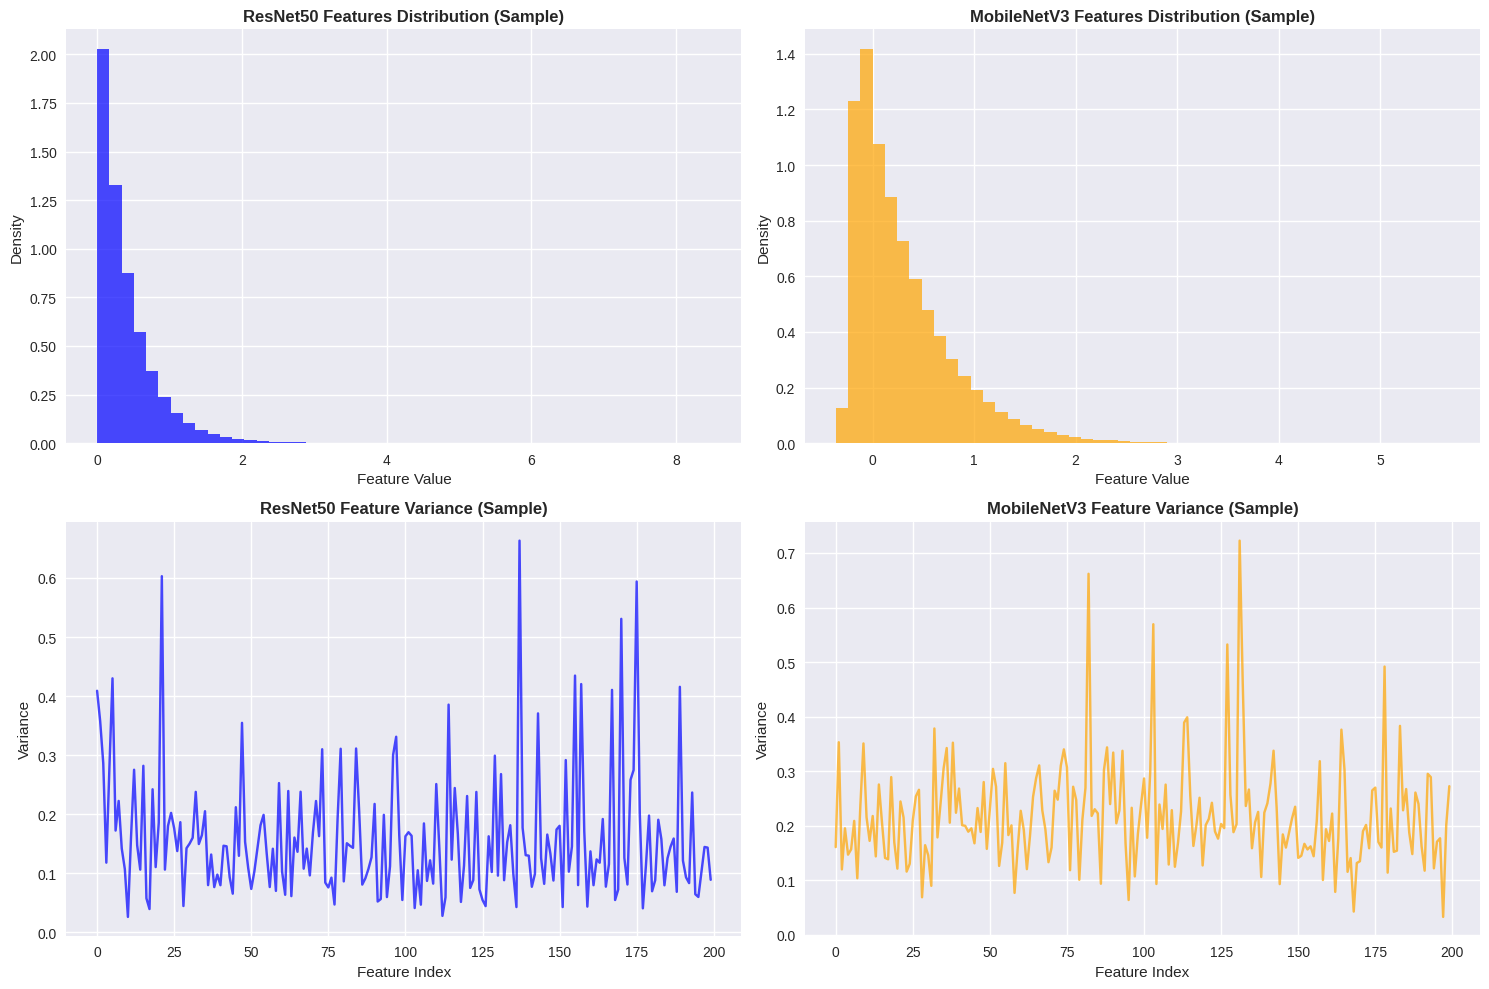

Feature analysis visualization saved: ./svm_models/visualizations/feature_analysis.png


In [5]:
os.makedirs('./svm_models/visualizations', exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sample_features_resnet = resnet50_train[:, :100]
axes[0, 0].hist(sample_features_resnet.flatten(), bins=50, alpha=0.7, color='blue', density=True)
axes[0, 0].set_title('ResNet50 Features Distribution (Sample)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Feature Value')
axes[0, 0].set_ylabel('Density')

sample_features_mobile = mobilenetv3_train[:, :100]
axes[0, 1].hist(sample_features_mobile.flatten(), bins=50, alpha=0.7, color='orange', density=True)
axes[0, 1].set_title('MobileNetV3 Features Distribution (Sample)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Feature Value')
axes[0, 1].set_ylabel('Density')

resnet_var = np.var(resnet50_train, axis=0)
mobile_var = np.var(mobilenetv3_train, axis=0)

axes[1, 0].plot(resnet_var[:200], color='blue', alpha=0.7)
axes[1, 0].set_title('ResNet50 Feature Variance (Sample)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Feature Index')
axes[1, 0].set_ylabel('Variance')

axes[1, 1].plot(mobile_var[:200], color='orange', alpha=0.7)
axes[1, 1].set_title('MobileNetV3 Feature Variance (Sample)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Feature Index')
axes[1, 1].set_ylabel('Variance')

plt.tight_layout()
plt.savefig('./svm_models/visualizations/feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature analysis visualization saved: ./svm_models/visualizations/feature_analysis.png")

## Train SVM Models

In [6]:
def create_subset(X, y, subset_percentage):
    subset_size = int(len(X) * subset_percentage)
    subset_size = max(MIN_SUBSET_SIZE, min(subset_size, MAX_SUBSET_SIZE))
    
    from sklearn.model_selection import train_test_split
    
    X_subset, _, y_subset, _ = train_test_split(
        X, y, 
        train_size=subset_size, 
        stratify=y, 
        random_state=42
    )
    
    actual_percentage = len(X_subset) / len(X)
    
    print(f"Subset created: {len(X_subset):,} samples from {len(X):,} ({actual_percentage*100:.1f}%)")
    
    return X_subset, y_subset, len(X_subset), actual_percentage

def optimize_svm(X, y, kernel_type='rbf', n_iter=30):
    print(f"Optimizing {kernel_type.upper()} SVM hyperparameters...")
    print(f"- Dataset: {X.shape[0]:,} samples, {X.shape[1]:,} features")
    print(f"- Search iterations: {n_iter}")
    print(f"- Cross-validation: {CV_FOLDS}-fold")
    
    if kernel_type == 'rbf':
        param_dist = {
            'C': loguniform(0.01, 100),
            'gamma': loguniform(1e-6, 1e-1)
        }
    elif kernel_type == 'poly':
        param_dist = {
            'C': loguniform(0.01, 100),
            'gamma': loguniform(1e-6, 1e-1),
            'degree': [2, 3, 4],
            'coef0': uniform(0, 1)
        }
    else:
        raise ValueError(f"Unsupported kernel type: {kernel_type}")
    
    svm_classifier = SVC(kernel=kernel_type, random_state=42)
    
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)
    
    random_search = RandomizedSearchCV(
        estimator=svm_classifier,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    try:
        with tqdm(total=n_iter, desc=f"Optimizing {kernel_type.upper()}") as pbar:
            random_search.fit(X, y)
            pbar.update(n_iter)
        
        best_params = random_search.best_params_
        best_score = random_search.best_score_
        
        print(f"Optimization complete!")
        print(f"   Best CV Score: {best_score:.4f}")
        print(f"   Best Parameters: {best_params}")
        
        return best_params, best_score
        
    except Exception as e:
        print(f"Optimization failed: {e}")
        return None, None

print("SVM training functions loaded successfully!")

SVM training functions loaded successfully!


In [7]:
results = {}
models = {}
scalers = {}
training_times = {}

os.makedirs("svm_models", exist_ok=True)

print("Starting SVM Training Pipeline")
print("=" * 50)
total_start_time = time.time()

architectures = ['ResNet50', 'MobileNetV3']
kernels = ['rbf', 'poly']
total_combinations = len(architectures) * len(kernels)

combination_count = 0

for arch_name, features in feature_sets.items():
    print(f"\n{'='*20} Processing {arch_name} {'='*20}")
    arch_start_time = time.time()
    
    X_train_full = features['train']
    X_val = features['val']
    
    print(f"Feature dimensions: {X_train_full.shape}")
    
    print("Standardizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_val_scaled = scaler.transform(X_val)
    scalers[arch_name] = scaler
    
    print(f"Standardization complete. Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")
    
    if USE_SUBSET:
        X_subset, y_subset, subset_size, subset_pct = create_subset(
            X_train_scaled, y_train, SUBSET_PERCENTAGE
        )
        print(f"Using subset: {subset_size:,} samples ({subset_pct*100:.1f}%) for hyperparameter optimization")
    else:
        X_subset, y_subset = X_train_scaled, y_train
        subset_size = len(y_train)
        subset_pct = 1.0
        print(f"Using full dataset: {len(y_train):,} samples for hyperparameter optimization")
    
    for kernel in kernels:
        combination_count += 1
        print(f"\n--- Training {kernel.upper()} kernel ({combination_count}/{total_combinations}) ---")
        
        n_iter = RBF_ITERATIONS if kernel == 'rbf' else POLY_ITERATIONS
        
        hp_start_time = time.time()
        best_params, best_score = optimize_svm(
            X_subset, y_subset, kernel_type=kernel, n_iter=n_iter
        )
        hp_time = time.time() - hp_start_time
        
        if best_params is None:
            print(f"Failed to optimize {arch_name} {kernel}")
            continue
            
        print(f"Training final model on full training data ({len(y_train):,} samples)...")
        final_model = SVC(**best_params, kernel=kernel, random_state=42)
        
        final_train_start = time.time()
        final_model.fit(X_train_scaled, y_train)
        final_train_time = time.time() - final_train_start
        
        total_train_time = hp_time + final_train_time
        
        val_pred = final_model.predict(X_val_scaled)
        val_accuracy = accuracy_score(y_val, val_pred)
        
        precision, recall, f1, support = precision_recall_fscore_support(y_val, val_pred, average='weighted')
        
        model_key = f"{arch_name}_{kernel}"
        results[model_key] = {
            'best_params': best_params,
            'hp_score': best_score,
            'val_accuracy': val_accuracy,
            'val_precision': precision,
            'val_recall': recall,
            'val_f1': f1,
            'hp_time': hp_time,
            'final_train_time': final_train_time,
            'total_train_time': total_train_time,
            'architecture': arch_name,
            'kernel': kernel,
            'subset_size': subset_size,
            'subset_percentage': subset_pct
        }
        models[model_key] = final_model
        
        print(f"- {model_key} completed!")
        print(f"   HP Score: {best_score:.4f}")
        print(f"   Val Accuracy: {val_accuracy:.4f}")
        print(f"   Val F1-Score: {f1:.4f}")
        print(f"   HP Time: {hp_time:.1f}s")
        print(f"   Final Train Time: {final_train_time:.1f}s")
        print(f"   Total Time: {total_train_time:.1f}s")
        
        model_path = f"svm_models/{model_key}_model.pkl"
        with open(model_path, 'wb') as f:
            pickle.dump(final_model, f)
        print(f"   Model saved: {model_path}")
    
    arch_time = time.time() - arch_start_time
    training_times[arch_name] = arch_time
    print(f"\n{arch_name} total processing time: {arch_time:.1f}s")

total_time = time.time() - total_start_time
print(f"\nAll SVM training completed!")
print(f"Total models trained: {len(results)}")
print(f"Total processing time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"Average time per model: {total_time/len(results):.1f}s")

Starting SVM Training Pipeline

==================== Processing ResNet50 ====================
Feature dimensions: (12600, 2048)
Standardizing features...
Standardization complete. Mean: 0.0000, Std: 1.0000
Subset created: 3,150 samples from 12,600 (25.0%)
Using subset: 3,150 samples (25.0%) for hyperparameter optimization

--- Training RBF kernel (1/4) ---
Optimizing RBF SVM hyperparameters...
- Dataset: 3,150 samples, 2,048 features
- Search iterations: 20
- Cross-validation: 3-fold


Optimizing RBF:   0%|          | 0/20 [00:00<?, ?it/s]

Optimization complete!
   Best CV Score: 0.9654
   Best Parameters: {'C': 8.471801418819979, 'gamma': 0.0009846738873614568}
Training final model on full training data (12,600 samples)...
- ResNet50_rbf completed!
   HP Score: 0.9654
   Val Accuracy: 0.9796
   Val F1-Score: 0.9797
   HP Time: 308.0s
   Final Train Time: 113.2s
   Total Time: 421.2s
   Model saved: svm_models/ResNet50_rbf_model.pkl

--- Training POLY kernel (2/4) ---
Optimizing POLY SVM hyperparameters...
- Dataset: 3,150 samples, 2,048 features
- Search iterations: 20
- Cross-validation: 3-fold


Optimizing POLY:   0%|          | 0/20 [00:00<?, ?it/s]

Optimization complete!
   Best CV Score: 0.9759
   Best Parameters: {'C': 0.06788387912421222, 'coef0': 0.5677003278199915, 'degree': 2, 'gamma': 0.07045683638454503}
Training final model on full training data (12,600 samples)...
- ResNet50_poly completed!
   HP Score: 0.9759
   Val Accuracy: 0.9844
   Val F1-Score: 0.9845
   HP Time: 254.0s
   Final Train Time: 64.5s
   Total Time: 318.5s
   Model saved: svm_models/ResNet50_poly_model.pkl

ResNet50 total processing time: 786.2s

==================== Processing MobileNetV3 ====================
Feature dimensions: (12600, 960)
Standardizing features...
Standardization complete. Mean: -0.0000, Std: 1.0000
Subset created: 3,150 samples from 12,600 (25.0%)
Using subset: 3,150 samples (25.0%) for hyperparameter optimization

--- Training RBF kernel (3/4) ---
Optimizing RBF SVM hyperparameters...
- Dataset: 3,150 samples, 960 features
- Search iterations: 20
- Cross-validation: 3-fold


Optimizing RBF:   0%|          | 0/20 [00:00<?, ?it/s]

Optimization complete!
   Best CV Score: 0.9670
   Best Parameters: {'C': 8.471801418819979, 'gamma': 0.0009846738873614568}
Training final model on full training data (12,600 samples)...
- MobileNetV3_rbf completed!
   HP Score: 0.9670
   Val Accuracy: 0.9833
   Val F1-Score: 0.9833
   HP Time: 124.6s
   Final Train Time: 28.5s
   Total Time: 153.1s
   Model saved: svm_models/MobileNetV3_rbf_model.pkl

--- Training POLY kernel (4/4) ---
Optimizing POLY SVM hyperparameters...
- Dataset: 3,150 samples, 960 features
- Search iterations: 20
- Cross-validation: 3-fold


Optimizing POLY:   0%|          | 0/20 [00:00<?, ?it/s]

Optimization complete!
   Best CV Score: 0.9724
   Best Parameters: {'C': 0.018205657658407266, 'coef0': 0.9488855372533332, 'degree': 3, 'gamma': 0.01101505679026964}
Training final model on full training data (12,600 samples)...
- MobileNetV3_poly completed!
   HP Score: 0.9724
   Val Accuracy: 0.9870
   Val F1-Score: 0.9870
   HP Time: 111.0s
   Final Train Time: 43.2s
   Total Time: 154.2s
   Model saved: svm_models/MobileNetV3_poly_model.pkl

MobileNetV3 total processing time: 324.7s

All SVM training completed!
Total models trained: 4
Total processing time: 1110.9s (18.5 minutes)
Average time per model: 277.7s


## Training Result & Performance Analysis

In [8]:
print("📊 TRAINING RESULTS ANALYSIS")
print("=" * 50)

if results:
    results_df = pd.DataFrame(results).T
    results_df = results_df.round(4)
    
    print("\nPerformance Comparison:")
    display_cols = ['hp_score', 'val_accuracy', 'val_f1', 'total_train_time', 'subset_percentage']
    print(results_df[display_cols])
    
    print(f"\n🏆 Best Model Analysis:")
    best_model_idx = results_df['val_accuracy'].idxmax()
    best_model = results_df.loc[best_model_idx]
    
    print(f"   🥇 Best Overall: {best_model.name}")
    print(f"      Validation Accuracy: {best_model['val_accuracy']:.4f}")
    print(f"      Validation F1-Score: {best_model['val_f1']:.4f}")
    print(f"      Total Training Time: {best_model['total_train_time']:.1f}s")
    print(f"      Hyperparameters: {best_model['best_params']}")
    
    print(f"\nBest by Architecture:")
    for arch in ['ResNet50', 'MobileNetV3']:
        arch_results = results_df[results_df['architecture'] == arch]
        if not arch_results.empty:
            best_arch_idx = arch_results['val_accuracy'].idxmax()
            best_arch = arch_results.loc[best_arch_idx]
            print(f"   {arch}: {best_arch.name}")
            print(f"-     Accuracy: {best_arch['val_accuracy']:.4f}")
            print(f"-     F1-Score: {best_arch['val_f1']:.4f}")
            print(f"-     Time: {best_arch['total_train_time']:.1f}s")
    
    print(f"\n🔧 Best by Kernel:")
    for kernel in ['rbf', 'poly']:
        kernel_results = results_df[results_df['kernel'] == kernel]
        if not kernel_results.empty:
            best_kernel_idx = kernel_results['val_accuracy'].idxmax()
            best_kernel = kernel_results.loc[best_kernel_idx]
            print(f"   {kernel.upper()}: {best_kernel.name}")
            print(f"      Accuracy: {best_kernel['val_accuracy']:.4f}")
            print(f"      F1-Score: {best_kernel['val_f1']:.4f}")
    
    print(f"\nTraining Efficiency:")
    print(f"-  Fastest Training: {results_df.loc[results_df['total_train_time'].idxmin()].name} ({results_df['total_train_time'].min():.1f}s)")
    print(f"-  Slowest Training: {results_df.loc[results_df['total_train_time'].idxmax()].name} ({results_df['total_train_time'].max():.1f}s)")
    print(f"-  Average Training Time: {results_df['total_train_time'].mean():.1f}s")
    
    print(f"\nSaved Models:")
    for model_name in models.keys():
        print(f"  -  {model_name}_model.pkl")
    
else:
    print("❌ No results found. Please run training first.")

📊 TRAINING RESULTS ANALYSIS

Performance Comparison:
                  hp_score val_accuracy    val_f1 total_train_time  \
ResNet50_rbf      0.965397      0.97963  0.979656       421.224388   
ResNet50_poly     0.975873     0.984444  0.984453       318.489416   
MobileNetV3_rbf   0.966984     0.983333  0.983332       153.102672   
MobileNetV3_poly  0.972381     0.987037   0.98704       154.202889   

                 subset_percentage  
ResNet50_rbf                  0.25  
ResNet50_poly                 0.25  
MobileNetV3_rbf               0.25  
MobileNetV3_poly              0.25  

🏆 Best Model Analysis:
   🥇 Best Overall: MobileNetV3_poly
      Validation Accuracy: 0.9870
      Validation F1-Score: 0.9870
      Total Training Time: 154.2s
      Hyperparameters: {'C': 0.018205657658407266, 'coef0': 0.9488855372533332, 'degree': 3, 'gamma': 0.01101505679026964}

Best by Architecture:
   ResNet50: ResNet50_poly
-     Accuracy: 0.9844
-     F1-Score: 0.9845
-     Time: 318.5s
   MobileNe


Creating Confusion Matrices


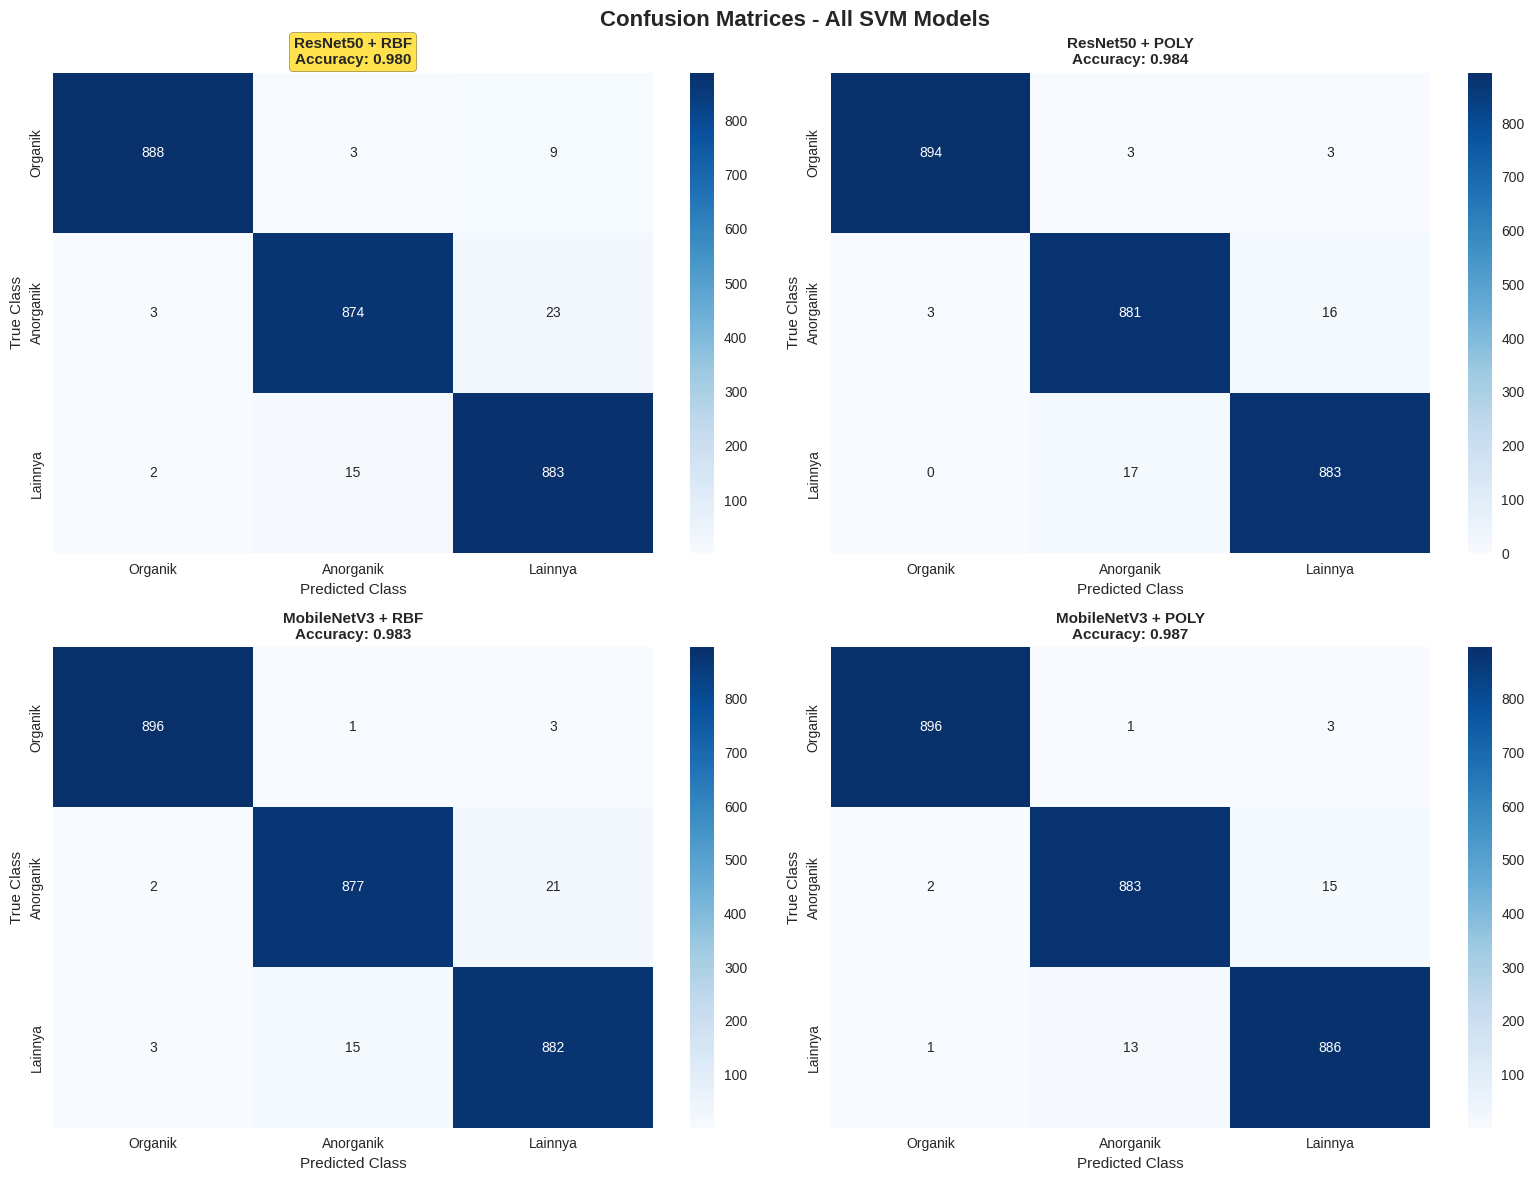

Confusion matrices saved


In [16]:
    print("\nCreating Confusion Matrices")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Confusion Matrices - All SVM Models', fontsize=16, fontweight='bold')
    
    model_idx = 0
    for arch_name in ['ResNet50', 'MobileNetV3']:
        for kernel in ['rbf', 'poly']:
            model_key = f"{arch_name}_{kernel}"
            
            if model_key in models:
                model = models[model_key]
                features = feature_sets[arch_name]['val']
                scaler = scalers[arch_name]
                
                X_val_scaled = scaler.transform(features)
                y_pred = model.predict(X_val_scaled)
                
                cm = confusion_matrix(y_val, y_pred)
                
                row, col = model_idx // 2, model_idx % 2
                ax = axes[row, col]
                
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                           xticklabels=CLASSES, yticklabels=CLASSES, ax=ax)
                
                accuracy = results[model_key]['val_accuracy']
                
                title = f'{arch_name} + {kernel.upper()}\nAccuracy: {accuracy:.3f}'
                if model_key == best_model_key:
                    ax.set_title(title, fontweight='bold', fontsize=11,
                               bbox=dict(boxstyle="round,pad=0.3", facecolor="gold", alpha=0.7))
                else:
                    ax.set_title(title, fontweight='bold', fontsize=11)
                
                ax.set_xlabel('Predicted Class')
                ax.set_ylabel('True Class')
                
                model_idx += 1
    
    plt.tight_layout()
    plt.savefig('./svm_models/visualizations/confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Confusion matrices saved")


Creating Performance Metrics Comparison


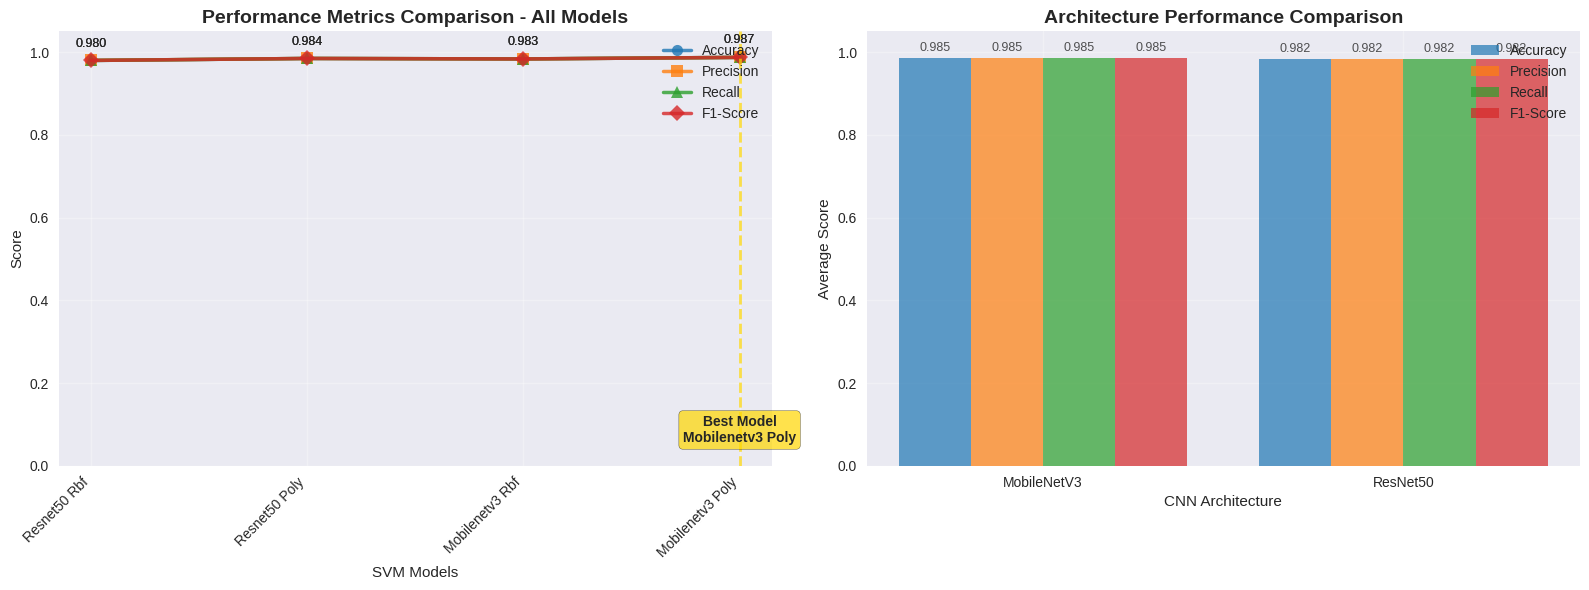

Performance metrics comparison saved


In [17]:
    print("\nCreating Performance Metrics Comparison")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    model_names = [name.replace('_', ' ').title() for name in results_df.index]
    metrics = ['val_accuracy', 'val_precision', 'val_recall', 'val_f1']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    markers = ['o', 's', '^', 'D']
    
    x_pos = np.arange(len(model_names))
    
    for i, (metric, label, color, marker) in enumerate(zip(metrics, metric_labels, colors, markers)):
        values = results_df[metric].values
        ax1.plot(x_pos, values, marker=marker, linewidth=2.5, markersize=8, 
                label=label, color=color, alpha=0.8)
        
        for j, value in enumerate(values):
            ax1.annotate(f'{value:.3f}', (x_pos[j], value), 
                        textcoords="offset points", xytext=(0,10), ha='center',
                        fontsize=9, alpha=0.7)
    
    ax1.set_title('Performance Metrics Comparison - All Models', fontweight='bold', fontsize=14)
    ax1.set_xlabel('SVM Models')
    ax1.set_ylabel('Score')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.05)
    
    best_acc_idx = results_df['val_accuracy'].idxmax()
    best_acc_pos = list(results_df.index).index(best_acc_idx)
    ax1.axvline(x=best_acc_pos, color='gold', linestyle='--', alpha=0.7, linewidth=2)
    ax1.text(best_acc_pos, 0.05, f'Best Model\n{best_acc_idx.replace("_", " ").title()}', 
             ha='center', va='bottom', fontweight='bold', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="gold", alpha=0.7))
    
    arch_comparison = results_df.groupby('architecture')[metrics].mean()
    kernel_comparison = results_df.groupby('kernel')[metrics].mean()
    
    x_arch = np.arange(len(arch_comparison.index))
    width = 0.2
    
    for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
        offset = (i - 1.5) * width
        bars = ax2.bar(x_arch + offset, arch_comparison[metric], width, 
                      label=label, color=color, alpha=0.7)
        
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9, alpha=0.8)
    
    ax2.set_title('Architecture Performance Comparison', fontweight='bold', fontsize=14)
    ax2.set_xlabel('CNN Architecture')
    ax2.set_ylabel('Average Score')
    ax2.set_xticks(x_arch)
    ax2.set_xticklabels(arch_comparison.index)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.savefig('./svm_models/visualizations/performance_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Performance metrics comparison saved")


Creating Training Efficiency Analysis


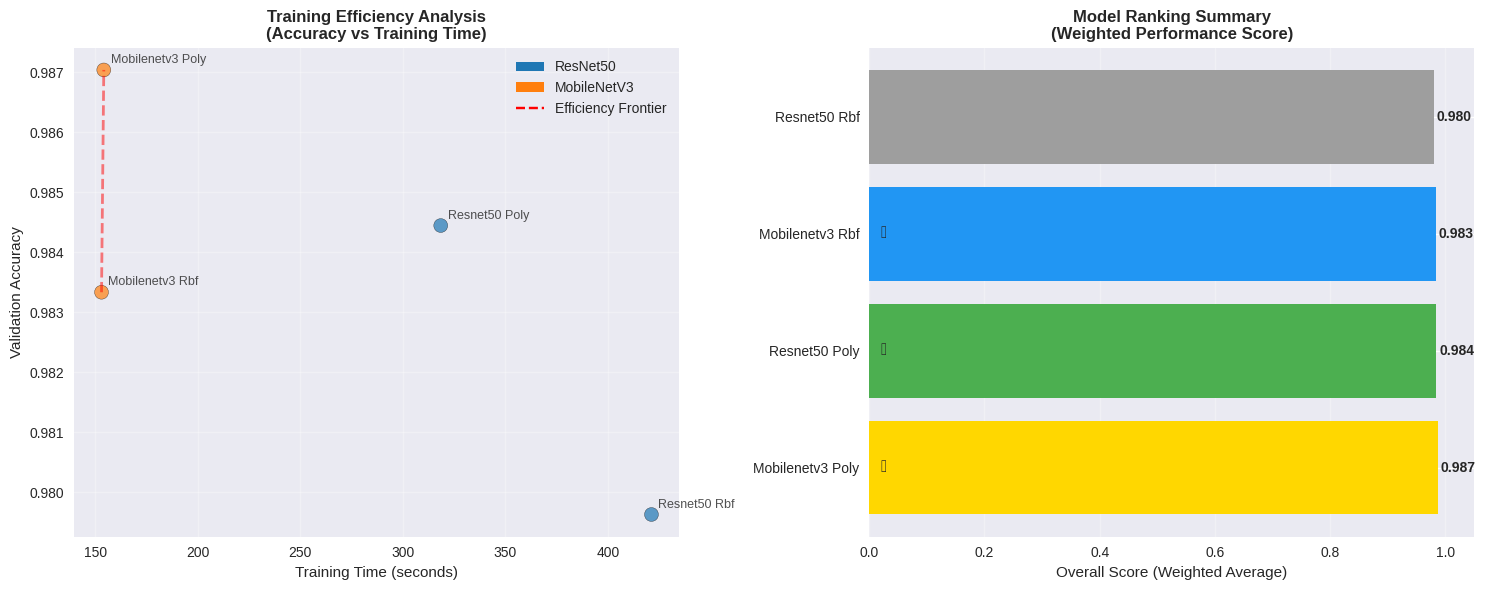

Training efficiency analysis saved

Final Model Ranking:
   🥇 Mobilenetv3 Poly: 0.987
      Acc: 0.987 | F1: 0.987 | Time: 154.2s
   🥈 Resnet50 Poly: 0.984
      Acc: 0.984 | F1: 0.984 | Time: 318.5s
   🥉 Mobilenetv3 Rbf: 0.983
      Acc: 0.983 | F1: 0.983 | Time: 153.1s
   4️⃣ Resnet50 Rbf: 0.980
      Acc: 0.980 | F1: 0.980 | Time: 421.2s
No results found for visualization. Please run training first.


In [20]:
    print("\nCreating Training Efficiency Analysis")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    accuracies = results_df['val_accuracy'].values
    times = results_df['total_train_time'].values
    model_names = [name.replace('_', ' ').title() for name in results_df.index]
    
    colors = []
    for model_name in results_df.index:
        if 'ResNet50' in model_name:
            colors.append('#1f77b4')  # Blue for ResNet50
        else:
            colors.append('#ff7f0e')  # Orange for MobileNetV3
    
    scatter = ax1.scatter(times, accuracies, c=colors, s=100, alpha=0.7, edgecolors='black')
    
    for i, (time, acc, name) in enumerate(zip(times, accuracies, model_names)):
        ax1.annotate(name, (time, acc), xytext=(5, 5), textcoords='offset points',
                    fontsize=9, alpha=0.8)
    
    efficiency_frontier = []
    for i in range(len(times)):
        is_efficient = True
        for j in range(len(times)):
            if i != j and times[j] <= times[i] and accuracies[j] >= accuracies[i]:
                if times[j] < times[i] or accuracies[j] > accuracies[i]:
                    is_efficient = False
                    break
        if is_efficient:
            efficiency_frontier.append(i)
    
    if len(efficiency_frontier) > 1:
        frontier_times = [times[i] for i in efficiency_frontier]
        frontier_accs = [accuracies[i] for i in efficiency_frontier]
        sorted_frontier = sorted(zip(frontier_times, frontier_accs))
        frontier_times, frontier_accs = zip(*sorted_frontier)
        ax1.plot(frontier_times, frontier_accs, 'r--', alpha=0.5, linewidth=2, 
                label='Efficiency Frontier')
    
    ax1.set_title('Training Efficiency Analysis\n(Accuracy vs Training Time)', fontweight='bold')
    ax1.set_xlabel('Training Time (seconds)')
    ax1.set_ylabel('Validation Accuracy')
    ax1.grid(True, alpha=0.3)
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#1f77b4', label='ResNet50'),
                      Patch(facecolor='#ff7f0e', label='MobileNetV3')]
    if len(efficiency_frontier) > 1:
        legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', label='Efficiency Frontier'))
    ax1.legend(handles=legend_elements)
    
    weights = {'val_accuracy': 0.4, 'val_f1': 0.3, 'val_precision': 0.15, 'val_recall': 0.15}
    results_df['overall_score'] = sum(results_df[metric] * weight for metric, weight in weights.items())
    
    sorted_results = results_df.sort_values('overall_score', ascending=False)
    
    y_pos = np.arange(len(sorted_results))
    bars = ax2.barh(y_pos, sorted_results['overall_score'], 
                   color=['gold' if i == 0 else '#4CAF50' if i == 1 else '#2196F3' if i == 2 else '#9E9E9E' 
                         for i in range(len(sorted_results))])
    
    for i, (bar, score) in enumerate(zip(bars, sorted_results['overall_score'])):
        width = bar.get_width()
        ax2.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                f'{score:.3f}', ha='left', va='center', fontweight='bold')
        
        if i == 0:
            ax2.text(0.02, bar.get_y() + bar.get_height()/2, '🥇', 
                    ha='left', va='center', fontsize=12)
        elif i == 1:
            ax2.text(0.02, bar.get_y() + bar.get_height()/2, '🥈', 
                    ha='left', va='center', fontsize=12)
        elif i == 2:
            ax2.text(0.02, bar.get_y() + bar.get_height()/2, '🥉', 
                    ha='left', va='center', fontsize=12)
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([name.replace('_', ' ').title() for name in sorted_results.index])
    ax2.set_xlabel('Overall Score (Weighted Average)')
    ax2.set_title('Model Ranking Summary\n(Weighted Performance Score)', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.set_xlim(0, 1.05)
    
    plt.tight_layout()
    plt.savefig('./svm_models/visualizations/training_efficiency_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Training efficiency analysis saved")
    print(f"\nFinal Model Ranking:")
    for i, (model_name, row) in enumerate(sorted_results.iterrows()):
        rank_emoji = ['🥇', '🥈', '🥉', '4️⃣'][i] if i < 4 else f"{i+1}️⃣"
        print(f"   {rank_emoji} {model_name.replace('_', ' ').title()}: {row['overall_score']:.3f}")
        print(f"      Acc: {row['val_accuracy']:.3f} | F1: {row['val_f1']:.3f} | Time: {row['total_train_time']:.1f}s")
    
    else:
        print("No results found for visualization. Please run training first.")

## Save Training Result

In [21]:
OUTPUT_DIR = './svm_models'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Saving training results to: {OUTPUT_DIR}")

if results:
    results_df.to_csv(f'{OUTPUT_DIR}/training_results.csv', index=True)
    print(f"Results DataFrame saved: {OUTPUT_DIR}/training_results.csv")
    
    with open(f'{OUTPUT_DIR}/scalers.pkl', 'wb') as f:
        pickle.dump(scalers, f)
    print(f"Feature scalers saved: {OUTPUT_DIR}/scalers.pkl")
    
    training_config = {
        'subset_percentage': SUBSET_PERCENTAGE,
        'min_subset_size': MIN_SUBSET_SIZE,
        'max_subset_size': MAX_SUBSET_SIZE,
        'use_subset': USE_SUBSET,
        'rbf_iterations': RBF_ITERATIONS,
        'poly_iterations': POLY_ITERATIONS,
        'cv_folds': CV_FOLDS,
        'classes': CLASSES,
        'class_to_idx': CLASS_TO_IDX,
        'idx_to_class': IDX_TO_CLASS,
        'training_date': datetime.now().isoformat(),
        'total_training_time': total_time,
        'models_trained': len(results)
    }
    
    with open(f'{OUTPUT_DIR}/training_config.json', 'w') as f:
        json.dump(training_config, f, indent=2)
    print(f"Training configuration saved: {OUTPUT_DIR}/training_config.json")
    
    feature_stats = {
        'resnet50': resnet_stats,
        'mobilenetv3': mobilenet_stats
    }
    
    with open(f'{OUTPUT_DIR}/feature_stats.json', 'w') as f:
        json.dump(feature_stats, f, indent=2, default=str)
    print(f"Feature statistics saved: {OUTPUT_DIR}/feature_stats.json")
    
    print(f"\n📁 All saved files:")
    saved_files = os.listdir(OUTPUT_DIR)
    for file in sorted(saved_files):
        file_path = os.path.join(OUTPUT_DIR, file)
        if os.path.isfile(file_path):
            file_size = os.path.getsize(file_path) / 1024  # KB
            print(f"   📄 {file} ({file_size:.1f} KB)")
    
    print(f"\nAll training results saved successfully!")
    
else:
    print("No results to save. Please run training first.")

Saving training results to: ./svm_models
Results DataFrame saved: ./svm_models/training_results.csv
Feature scalers saved: ./svm_models/scalers.pkl
Training configuration saved: ./svm_models/training_config.json
Feature statistics saved: ./svm_models/feature_stats.json

📁 All saved files:
   📄 MobileNetV3_poly_model.pkl (32643.5 KB)
   📄 MobileNetV3_rbf_model.pkl (25259.3 KB)
   📄 ResNet50_poly_model.pkl (51952.6 KB)
   📄 ResNet50_rbf_model.pkl (82726.1 KB)
   📄 feature_stats.json (0.4 KB)
   📄 scalers.pkl (71.1 KB)
   📄 training_config.json (0.5 KB)
   📄 training_results.csv (1.3 KB)

All training results saved successfully!


## SVM Training Summary Report

In [22]:
if results:
    summary_report = f"""
JakOlah Classifier - SVM Training Summary Report

Training Overview
- CNN Architectures: ResNet50, MobileNetV3
- SVM Kernels: RBF, Polynomial
- Total Models Trained: {len(results)}
- Training Dataset: {len(y_train):,} samples
- Validation Dataset: {len(y_val):,} samples
- Classes: {len(CLASSES)} ({', '.join(CLASSES)})

Hyperparameter Optimization
- Method: RandomizedSearchCV
- Cross-Validation: {CV_FOLDS}-fold stratified
- Subset Usage: {USE_SUBSET} ({SUBSET_PERCENTAGE*100:.0f}% of training data)
- RBF Iterations: {RBF_ITERATIONS}
- Polynomial Iterations: {POLY_ITERATIONS}

Feature Processing
- ResNet50 Features: {resnet50_train.shape[1]:,} dimensions
- MobileNetV3 Features: {mobilenetv3_train.shape[1]:,} dimensions
- Standardization: StandardScaler (mean=0, std=1)
- Normalization: Essential for SVM performance

Training Results Summary
"""

    for model_name, result in results.items():
        arch = result['architecture']
        kernel = result['kernel'].upper()
        accuracy = result['val_accuracy']
        f1 = result['val_f1']
        train_time = result['total_train_time']
        
        summary_report += f"""
{arch} + {kernel} Kernel:
- Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)
- Validation F1-Score: {f1:.4f}
- Training Time: {train_time:.1f} seconds
- Best Hyperparameters: {result['best_params']}
"""

    best_model = results_df.loc[results_df['val_accuracy'].idxmax()]
    fastest_model = results_df.loc[results_df['total_train_time'].idxmin()]
    
    summary_report += f"""
Performance Analysis
- Best Overall Model: {best_model.name}
  * Accuracy: {best_model['val_accuracy']:.4f}
  * F1-Score: {best_model['val_f1']:.4f}
  * Training Time: {best_model['total_train_time']:.1f}s

- Fastest Training: {fastest_model.name}
  * Training Time: {fastest_model['total_train_time']:.1f}s
  * Accuracy: {fastest_model['val_accuracy']:.4f}

- Architecture Comparison:
  * ResNet50 Average Accuracy: {results_df[results_df['architecture']=='ResNet50']['val_accuracy'].mean():.4f}
  * MobileNetV3 Average Accuracy: {results_df[results_df['architecture']=='MobileNetV3']['val_accuracy'].mean():.4f}

- Kernel Comparison:
  * RBF Average Accuracy: {results_df[results_df['kernel']=='rbf']['val_accuracy'].mean():.4f}
  * Polynomial Average Accuracy: {results_df[results_df['kernel']=='poly']['val_accuracy'].mean():.4f}

Training Efficiency
- Total Training Time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)
- Average Time per Model: {results_df['total_train_time'].mean():.1f} seconds
- Subset Training Efficiency: ~{((1-SUBSET_PERCENTAGE)*100):.0f}% time reduction vs full dataset

Output Files
- Trained Models: {len(models)} SVM models (.pkl files)
- Training Results: training_results.csv
- Feature Scalers: scalers.pkl
- Training Configuration: training_config.json
- Feature Statistics: feature_stats.json
- Visualizations: feature_analysis.png, training_performance.png

Next Steps
1. Run 04-evaluation.ipynb for comprehensive model evaluation
2. Test model performance on unseen test dataset
3. Compare final model accuracies and computational efficiency
4. Generate confusion matrices and classification reports
"""

    print(summary_report)
    
    with open(f'{OUTPUT_DIR}/svm_training_report.md', 'w', encoding='utf-8') as f:
        f.write(summary_report)
    
    print(f"Training summary report saved: {OUTPUT_DIR}/svm_training_report.md")
    
else:
    print("No results available for report generation.")


JakOlah Classifier - SVM Training Summary Report

Training Overview
- CNN Architectures: ResNet50, MobileNetV3
- SVM Kernels: RBF, Polynomial
- Total Models Trained: 4
- Training Dataset: 12,600 samples
- Validation Dataset: 2,700 samples
- Classes: 3 (Organik, Anorganik, Lainnya)

Hyperparameter Optimization
- Method: RandomizedSearchCV
- Cross-Validation: 3-fold stratified
- Subset Usage: True (25% of training data)
- RBF Iterations: 20
- Polynomial Iterations: 20

Feature Processing
- ResNet50 Features: 2,048 dimensions
- MobileNetV3 Features: 960 dimensions
- Standardization: StandardScaler (mean=0, std=1)
- Normalization: Essential for SVM performance

Training Results Summary

ResNet50 + RBF Kernel:
- Validation Accuracy: 0.9796 (97.96%)
- Validation F1-Score: 0.9797
- Training Time: 421.2 seconds
- Best Hyperparameters: {'C': 8.471801418819979, 'gamma': 0.0009846738873614568}

ResNet50 + POLY Kernel:
- Validation Accuracy: 0.9844 (98.44%)
- Validation F1-Score: 0.9845
- Trainin

## Create Results ZIP Package

In [23]:
def create_svm_training_zip():
    zip_filename = '03-SVM-Training-Results.zip'
    
    print(f"Creating SVM training results ZIP: {zip_filename}")
    
    files_to_zip = [
        f'{OUTPUT_DIR}/training_results.csv',
        f'{OUTPUT_DIR}/scalers.pkl',
        f'{OUTPUT_DIR}/training_config.json',
        f'{OUTPUT_DIR}/feature_stats.json',
        f'{OUTPUT_DIR}/svm_training_report.md'
    ]
    
    for model_name in models.keys():
        model_file = f'{OUTPUT_DIR}/{model_name}_model.pkl'
        if os.path.exists(model_file):
            files_to_zip.append(model_file)
    
    viz_files = [
        f'{OUTPUT_DIR}/visualizations/feature_analysis.png',
        f'{OUTPUT_DIR}/visualizations/training_performance.png'
    ]
    
    for viz_file in viz_files:
        if os.path.exists(viz_file):
            files_to_zip.append(viz_file)
    
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        files_added = 0
        
        for file_path in files_to_zip:
            if os.path.exists(file_path):
                if 'visualizations' in file_path:
                    arcname = f"03-SVM-Training/visualizations/{os.path.basename(file_path)}"
                else:
                    arcname = f"03-SVM-Training/{os.path.basename(file_path)}"
                
                zipf.write(file_path, arcname)
                print(f"- Added: {os.path.basename(file_path)}")
                files_added += 1
            else:
                print(f"- Missing: {os.path.basename(file_path)}")
        
        if results:
            best_model = results_df.loc[results_df['val_accuracy'].idxmax()]
            
            readme_content = f"""# JakOlah Classifier - SVM Training Results

## Training Overview
- CNN Architectures: ResNet50, MobileNetV3
- SVM Kernels: RBF, Polynomial
- Total Models Trained: {len(results)}
- Training Method: RandomizedSearchCV with {CV_FOLDS}-fold CV
- Subset Training: {USE_SUBSET} ({SUBSET_PERCENTAGE*100:.0f}% efficiency)

## Best Model Results
- **Best Model**: {best_model.name}
- **Validation Accuracy**: {best_model['val_accuracy']:.4f} ({best_model['val_accuracy']*100:.2f}%)
- **F1-Score**: {best_model['val_f1']:.4f}
- **Training Time**: {best_model['total_train_time']:.1f} seconds

## Files Included

### Model Files
"""
            
            for model_name in models.keys():
                result = results[model_name]
                readme_content += f"- **{model_name}_model.pkl**: SVM model (Acc: {result['val_accuracy']:.3f})\n"
            
            readme_content += f"""
### Data & Configuration Files
- **training_results.csv**: Detailed performance metrics for all models
- **scalers.pkl**: Feature standardization scalers (required for inference)
- **training_config.json**: Training parameters and configuration
- **feature_stats.json**: CNN feature analysis statistics
- **svm_training_report.md**: Comprehensive training report

### Visualizations
- **feature_analysis.png**: CNN feature distribution and variance analysis
- **training_performance.png**: Model performance comparison charts

## Model Usage
```python
import pickle
from sklearn.preprocessing import StandardScaler

# Load model and scaler
with open('{best_model.name}_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)

# Use for prediction
X_scaled = scalers['{best_model['architecture']}'].transform(X_features)
predictions = model.predict(X_scaled)
```

## Performance Summary
- **ResNet50 Average Accuracy**: {results_df[results_df['architecture']=='ResNet50']['val_accuracy'].mean():.3f}
- **MobileNetV3 Average Accuracy**: {results_df[results_df['architecture']=='MobileNetV3']['val_accuracy'].mean():.3f}
- **RBF Kernel Average**: {results_df[results_df['kernel']=='rbf']['val_accuracy'].mean():.3f}
- **Polynomial Kernel Average**: {results_df[results_df['kernel']=='poly']['val_accuracy'].mean():.3f}

## Next Steps
1. Run 04-evaluation.ipynb for final model testing
2. Compare performance on test dataset
3. Generate final confusion matrices and reports
"""
            
            zipf.writestr('03-SVM-Training/README.md', readme_content)
            files_added += 1
    
    zip_size = os.path.getsize(zip_filename) / (1024 * 1024)
    print(f"\nSVM Training ZIP created:")
    print(f"-   File: {zip_filename}")
    print(f"-   Size: {zip_size:.2f} MB")
    print(f"-   Files: {files_added}")
    
    return zip_filename

if results:
    svm_training_zip = create_svm_training_zip()
    
    print(f"\nSVM Training Stage Complete!")
    print(f"-   Models trained: {len(results)}")
    print(f"-   Best accuracy: {results_df['val_accuracy'].max():.4f}")
    print(f"-   Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"-   Results packaged: {svm_training_zip}")
    print(f"\nReady for evaluation phase!")
else:
    print("No results to package.")

Creating SVM training results ZIP: 03-SVM-Training-Results.zip
- Added: training_results.csv
- Added: scalers.pkl
- Added: training_config.json
- Added: feature_stats.json
- Added: svm_training_report.md
- Added: ResNet50_rbf_model.pkl
- Added: ResNet50_poly_model.pkl
- Added: MobileNetV3_rbf_model.pkl
- Added: MobileNetV3_poly_model.pkl
- Added: feature_analysis.png

SVM Training ZIP created:
-   File: 03-SVM-Training-Results.zip
-   Size: 102.08 MB
-   Files: 11

SVM Training Stage Complete!
-   Models trained: 4
-   Best accuracy: 0.9870
-   Total time: 1110.9s (18.5 min)
-   Results packaged: 03-SVM-Training-Results.zip

Ready for evaluation phase!
